In [1]:
import os
os.chdir('../')

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.linear_model import LogisticRegression

from src.DRL.qnetwork import QNetwork
from src.XAI.concept import Concept
from src.XAI.concepts import concept_instances

In [3]:
env_steps = Concept.load_concept_data()
model_path = "runs/20241115-172401/model_1990000.pt"
model = QNetwork(model_path=model_path)

concept = concept_instances['Visible ghost']
concept.prepare_data(env_steps, max_size=10000)

pygame 2.6.0 (SDL 2.28.4, Python 3.10.12)
Hello from the pygame community. https://www.pygame.org/contribute.html
Loaded model: 20241115-172401-1990000


In [4]:
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)
test_obs = torch.tensor(concept.test_obs.copy()).float()
test_values = torch.tensor(concept.test_values, dtype=torch.float32)
_, acts_dict_train = model(train_obs, return_acts=True)
_, acts_dict_test = model(test_obs, return_acts=True)

In [5]:
layer = 0
test_activations = acts_dict_test[layer]
test_activations.requires_grad_(True)
test_activations.shape

torch.Size([464, 32, 20, 20])

In [6]:
max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
max_q_values.backward(torch.ones_like(max_q_values))
activations_grad1 = test_activations.grad.clone()
test_activations.grad.zero_()
activations_grad1.shape

torch.Size([464, 32, 20, 20])

In [7]:
max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
grads = torch.autograd.grad(
    outputs=max_q_values,
    inputs=test_activations,
    grad_outputs=torch.ones_like(max_q_values),
    retain_graph=True,
    create_graph=True
)
test_activations.grad = grads[0]
activations_grad2 = test_activations.grad.clone()

test_activations.requires_grad_(False)

(activations_grad1 == activations_grad2).all()

tensor(True)

In [8]:
# manually compute gradients using the definition of derivatives
h = 0.001
activations_grad_manual = test_activations[0].clone().unsqueeze(0)
activations_grad_manual.shape

idx = (0, 0, 0, 3)

activation_plus_h = activations_grad_manual.clone()
activation_minus_h = activations_grad_manual.clone()
activation_plus_h[idx] += h
activation_minus_h[idx] -= h

forward_pass_plus_h = model.network[layer + 1:](activation_plus_h).max(dim=1)[0]
forward_pass_minus_h = model.network[layer + 1:](activation_minus_h).max(dim=1)[0]
activations_grad_manual = (forward_pass_plus_h - forward_pass_minus_h) / (2.0 * h)
print(activations_grad_manual)
print(activations_grad1[idx])

tensor([0.], grad_fn=<DivBackward0>)
tensor(0.)


In [9]:
x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

lr = LogisticRegression(max_iter=500, solver='liblinear', penalty='l1', C=1)
lr.fit(x_data_train, y_data_train)
lr.score(x_data_test, y_data_test)

0.9956896551724138

In [10]:
flat_activations_grad = activations_grad1.flatten(start_dim=1).cpu().numpy()
print(flat_activations_grad.shape)
flat_weights = lr.coef_[0]
print(flat_weights.shape)

(464, 12800)
(12800,)


In [11]:
norm_direction = flat_weights / np.linalg.norm(flat_weights)
directional_derivatives = np.dot(flat_activations_grad, norm_direction)

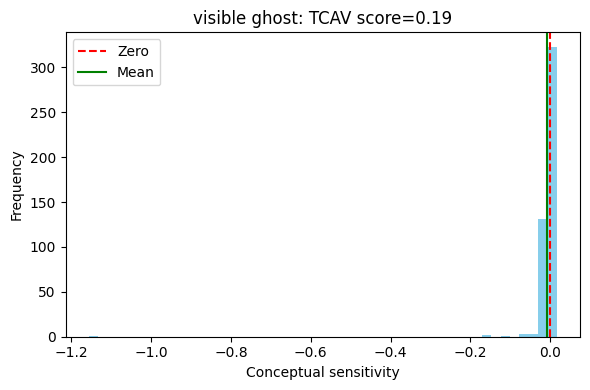

In [12]:
mean_value = np.mean(directional_derivatives)
positive_fraction = np.mean(directional_derivatives > 0)
plt.figure(figsize=(6, 4))
plt.hist(directional_derivatives, bins=50, color='skyblue')
plt.xlabel('Conceptual sensitivity')
plt.ylabel('Frequency')
plt.title(f"{concept.name}: TCAV score={positive_fraction:.2f}")

plt.axvline(x=0, color='r', linestyle='--', label='Zero')
plt.axvline(x=mean_value, color='green', linestyle='-', label='Mean')
plt.tight_layout()
plt.legend()
plt.show()

### Some action statistics

In [38]:
action_names = ['NOOP', 'LEFT', 'RIGHT', 'JUMP', 'DODGE']
concept = concept_instances['Visible ghost']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

train_ghost = train_obs[train_values == 1]
train_no_ghost = train_obs[train_values == 0]

indices_ghost = model(train_ghost).max(dim=1)[1].cpu().numpy()
indices_no_ghost = model(train_no_ghost).max(dim=1)[1].cpu().numpy()

print("Ghost actions (ghost / no ghost):")
for action in action_names:
    prob_ghost = 100 * np.mean(indices_ghost == action_names.index(action))
    prob_no_ghost = 100 * np.mean(indices_no_ghost == action_names.index(action))
    print(f"{action}: {prob_ghost:.2f}% / {prob_no_ghost:.2f}% = {prob_ghost / prob_no_ghost:.2f}")


Ghost actions (ghost / no ghost):
NOOP: 0.11% / 1.19% = 0.09
LEFT: 58.19% / 2.05% = 28.42
RIGHT: 34.59% / 76.29% = 0.45
JUMP: 3.56% / 16.70% = 0.21
DODGE: 3.56% / 3.77% = 0.94


In [39]:
concept = concept_instances['Visible gold coin']
concept.prepare_data(env_steps, max_size=10000)
train_obs = torch.tensor(concept.train_obs.copy()).float()
train_values = torch.tensor(concept.train_values, dtype=torch.float32)

train_coin = train_obs[train_values == 1]
train_no_coin = train_obs[train_values == 0]

indices_coin = model(train_coin).max(dim=1)[1].cpu().numpy()
indices_no_coin = model(train_no_coin).max(dim=1)[1].cpu().numpy()

print("Gold coin actions (coin / no coin):")
for action in action_names:
    prob_coin = 100 * np.mean(indices_coin == action_names.index(action))
    prob_no_coin = 100 * np.mean(indices_no_coin == action_names.index(action))
    print(f"{action}: {prob_coin:.2f}% / {prob_no_coin:.2f}% = {prob_coin / prob_no_coin:.2f}")

Gold coin actions (coin / no coin):
NOOP: 0.49% / 0.99% = 0.50
LEFT: 3.45% / 6.16% = 0.56
RIGHT: 74.88% / 69.46% = 1.08
JUMP: 14.29% / 19.46% = 0.73
DODGE: 6.90% / 3.94% = 1.75


### Putting it all together in a function


Layer 8 TCAV scores are either 0 or 1 as they are invariant to the data. plt.hist is a bit buggy when all values are the same it seems...

In [16]:
all_layers = list(range(9))
activation_layers = [1, 3, 5, 8]

In [17]:
def tcav_action(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [18]:
def tcav_max(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    max_q_values = model.network[layer + 1:](test_activations).max(dim=1)[0]
    max_q_values.backward(torch.ones_like(max_q_values))
    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    plt.figure(figsize=(6, 4))
    plt.hist(directional_derivatives, bins=50, color='skyblue')
    plt.xlabel('Conceptual sensitivity')
    plt.ylabel('Frequency')
    plt.title(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV score={positive_fraction:.2f}")

    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    plt.show()
    return round(positive_fraction, 3)


In [19]:
def tcav_softmax(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations).softmax(dim=1)[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [43]:
def tcav_linear_softmax(concept, layer):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()
    
    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    test_activations = acts_dict_test[layer]
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    
    fig, axes = plt.subplots(1, len(action_names), figsize=(5 * len(action_names), 4), sharey=True)
    if len(action_names) == 1:
        axes = [axes]  # Ensure axes is iterable

    for idx, action in enumerate(action_names):
        test_activations.requires_grad_(True)
        q_values = model.network[layer + 1:](test_activations)
        q_values = q_values / q_values.sum(dim=1, keepdim=True)
        q_values = q_values[:, idx]
        q_values.backward(torch.ones_like(q_values))
        activations_grad = test_activations.grad.clone()
        test_activations.requires_grad_(False)
        
        # Zero all gradients to prevent accumulation
        for param in model.network[layer + 1:].parameters():
            if param.grad is not None:
                param.grad.zero_()
        
        flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
        directional_derivatives = np.dot(flat_activations_grad, norm_direction)

        positive_fraction = np.mean(directional_derivatives > 0)
        
        ax = axes[idx]
        ax.hist(directional_derivatives, bins=50, color='skyblue')
        ax.set_xlabel('Conceptual sensitivity')
        ax.set_title(f"{action} | TCAV score={positive_fraction:.2f}")
        ax.axvline(x=0, color='r', linestyle='--', label='Zero')
        if idx == 0:
            ax.set_ylabel('Frequency')
        ax.legend()

    fig.suptitle(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | TCAV Scores per Action")
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()
    return round(positive_fraction, 3)

In [20]:
def tcav_action_ratio(concept, layer, action1, action2):
    concept.prepare_data(env_steps, max_size=10000)
    train_obs = torch.tensor(concept.train_obs.copy()).float()
    train_values = torch.tensor(concept.train_values, dtype=torch.float32)
    test_obs = torch.tensor(concept.test_obs.copy()).float()
    test_values = torch.tensor(concept.test_values, dtype=torch.float32)
    _, acts_dict_train = model(train_obs, return_acts=True)
    _, acts_dict_test = model(test_obs, return_acts=True)

    test_activations = acts_dict_test[layer]
    test_activations.requires_grad_(True)

    max_q_values = model.network[layer + 1:](test_activations)
    max_q_values = max_q_values[:, action1] / max_q_values[:, action2]
    max_q_values.backward(torch.ones_like(max_q_values))
    activations_grad = test_activations.grad.clone()
    test_activations.requires_grad_(False)

    x_data_train = acts_dict_train[layer].flatten(start_dim=1).cpu().numpy()
    y_data_train = train_values.view(train_values.shape[0]).cpu().numpy()
    x_data_test = acts_dict_test[layer].flatten(start_dim=1).cpu().numpy()
    y_data_test = test_values.view(test_values.shape[0]).cpu().numpy()

    lr = LogisticRegression(max_iter=100, solver='liblinear', penalty='l1', C=1)
    lr.fit(x_data_train, y_data_train)
    probe_accuracy = round(lr.score(x_data_test, y_data_test), 2)

    flat_activations_grad = activations_grad.flatten(start_dim=1).cpu().numpy()
    flat_weights = lr.coef_[0]
    norm_direction = flat_weights # / np.linalg.norm(flat_weights)
    directional_derivatives = np.dot(flat_activations_grad, norm_direction)

    positive_fraction = np.mean(directional_derivatives > 0)
    plt.figure(figsize=(6, 4))
    plt.hist(directional_derivatives, bins=50, color='skyblue')
    plt.xlabel('Conceptual sensitivity')
    plt.ylabel('Frequency')
    plt.title(f"{concept.name} | accuracy = {probe_accuracy} | Layer {layer} | {action_names[action1]} / {action_names[action2]} TCAV score={positive_fraction:.2f}")

    plt.axvline(x=0, color='r', linestyle='--', label='Zero')
    plt.tight_layout()
    plt.legend()
    plt.show()
    return round(positive_fraction, 3)

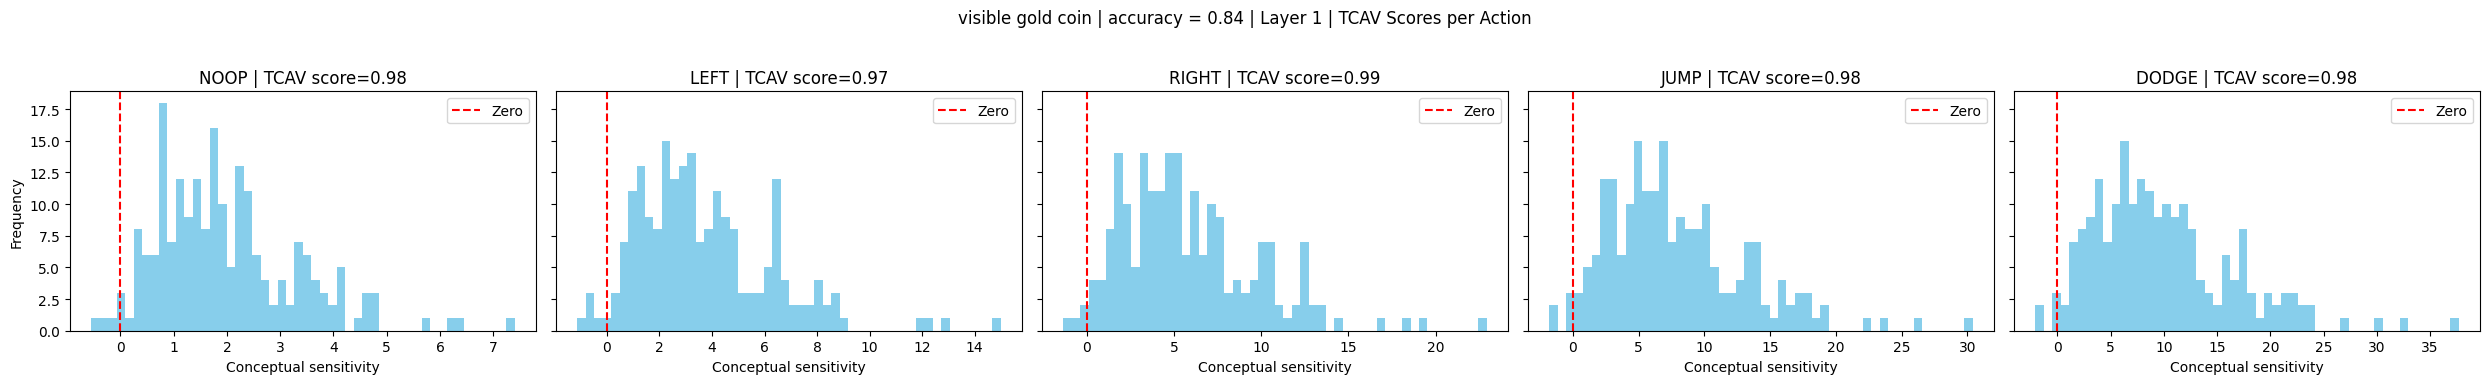

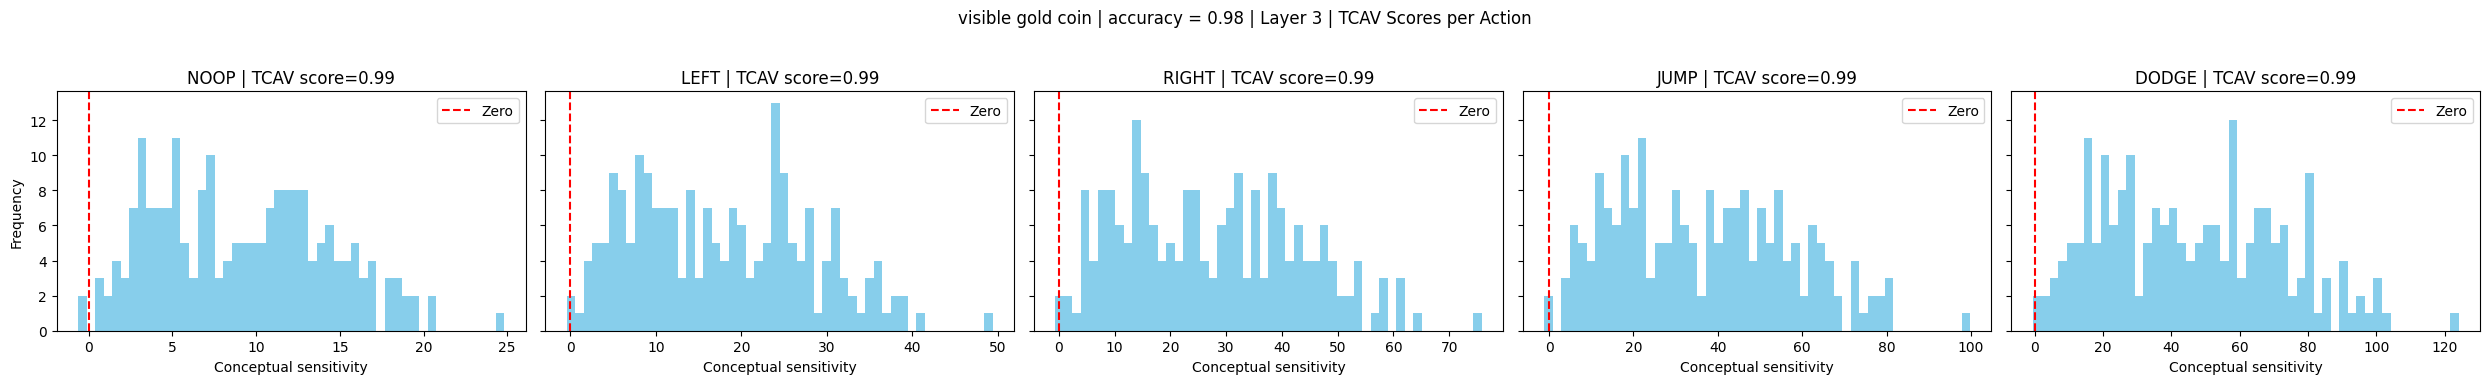

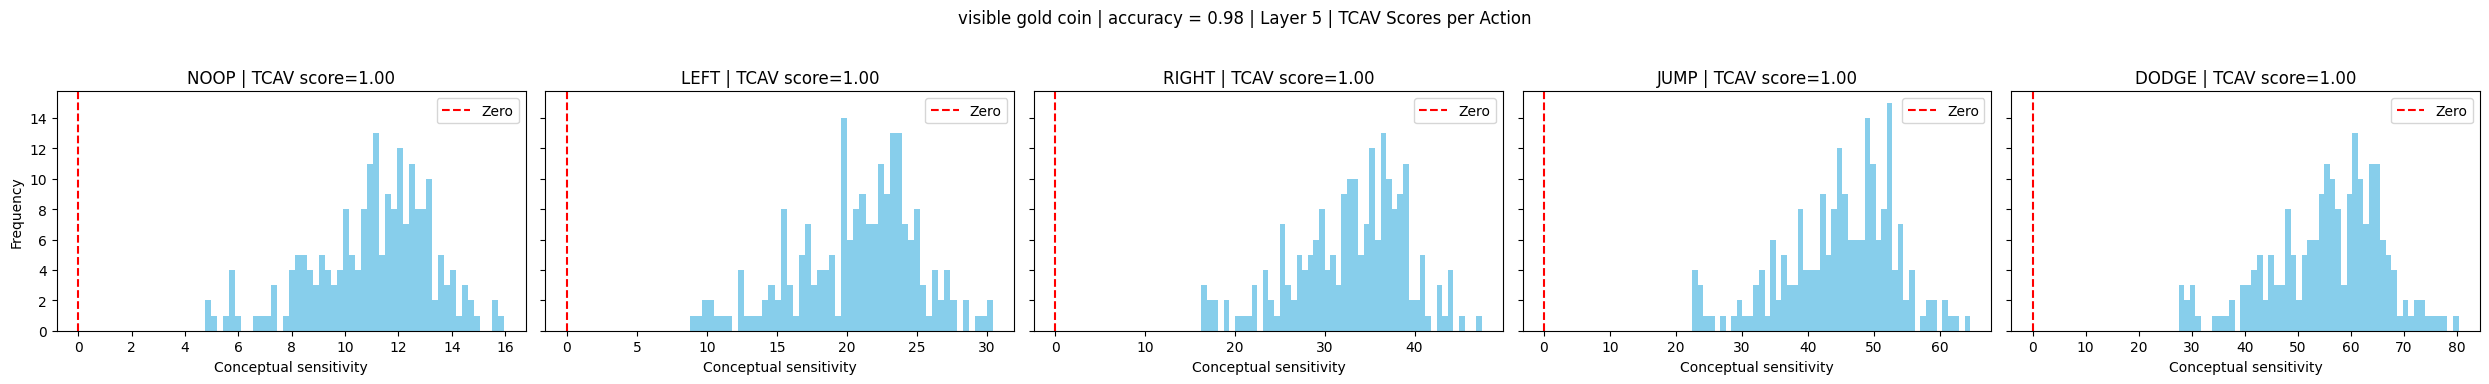

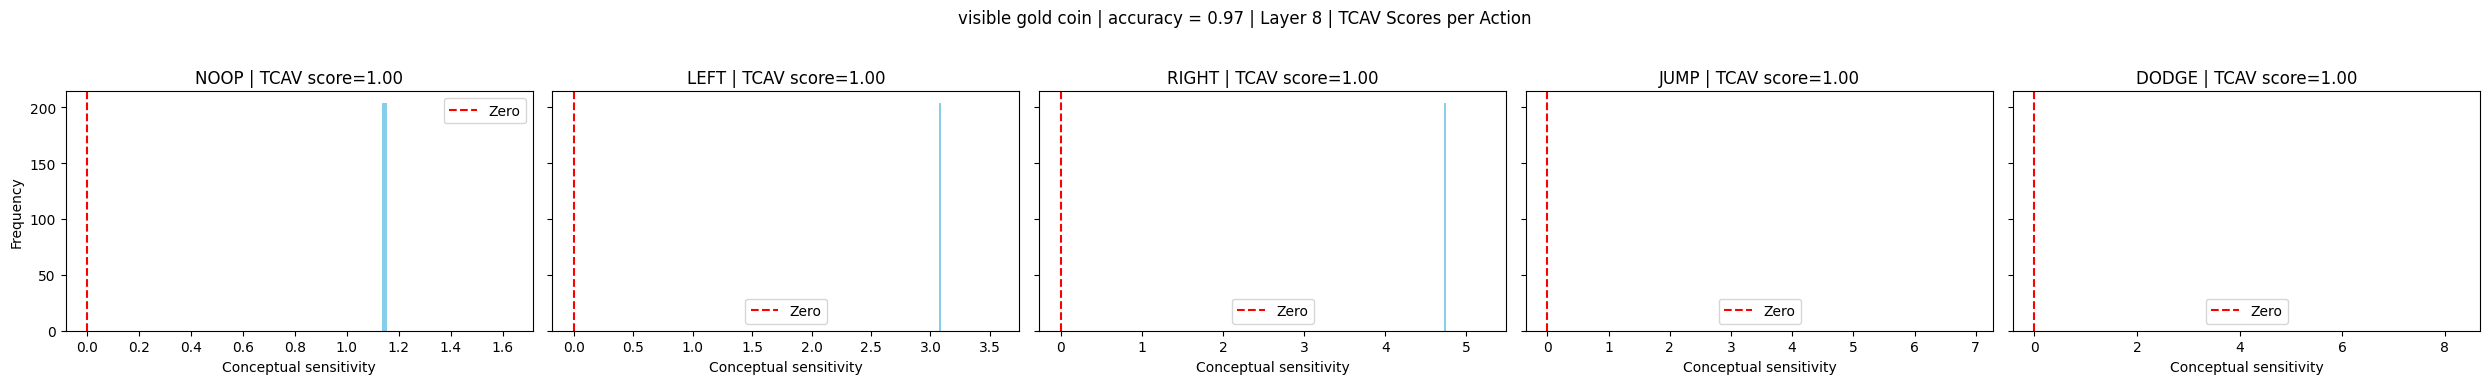

[0.98, 0.99, 1.0, 1.0]


In [21]:
scores = []
for layer in activation_layers:
    scores.append(tcav_action(concept_instances['Visible gold coin'], layer))
print(scores)

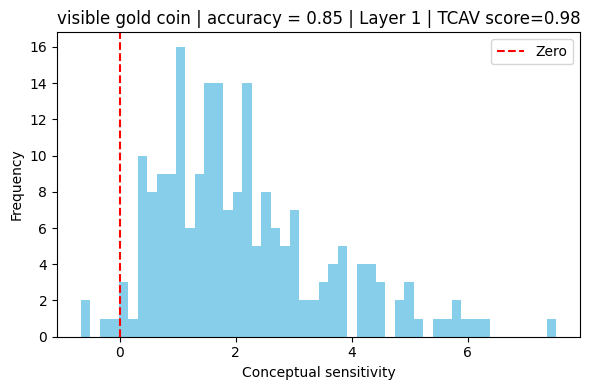

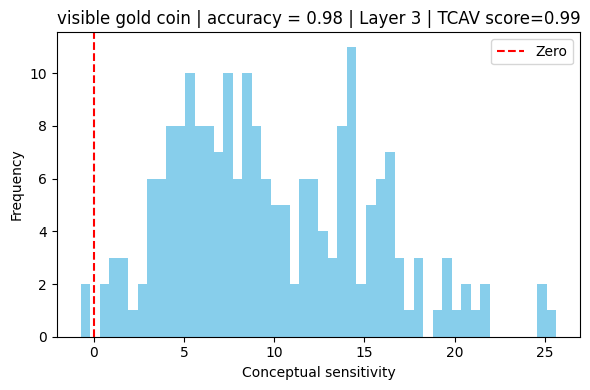

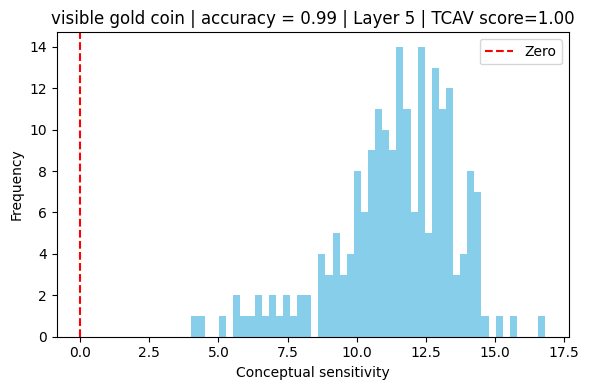

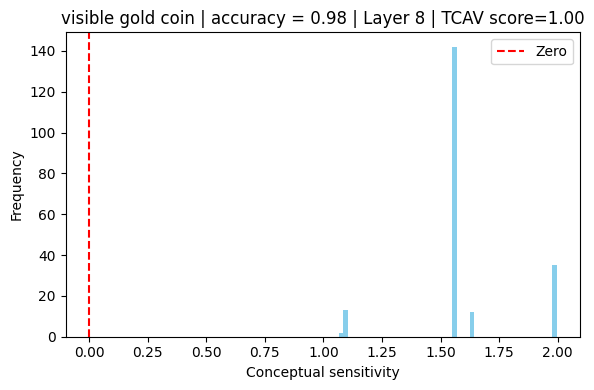

[0.98, 0.99, 1.0, 1.0]


In [22]:
scores = []
for layer in activation_layers:
    scores.append(tcav_max(concept_instances['Visible gold coin'], layer))
print(scores)

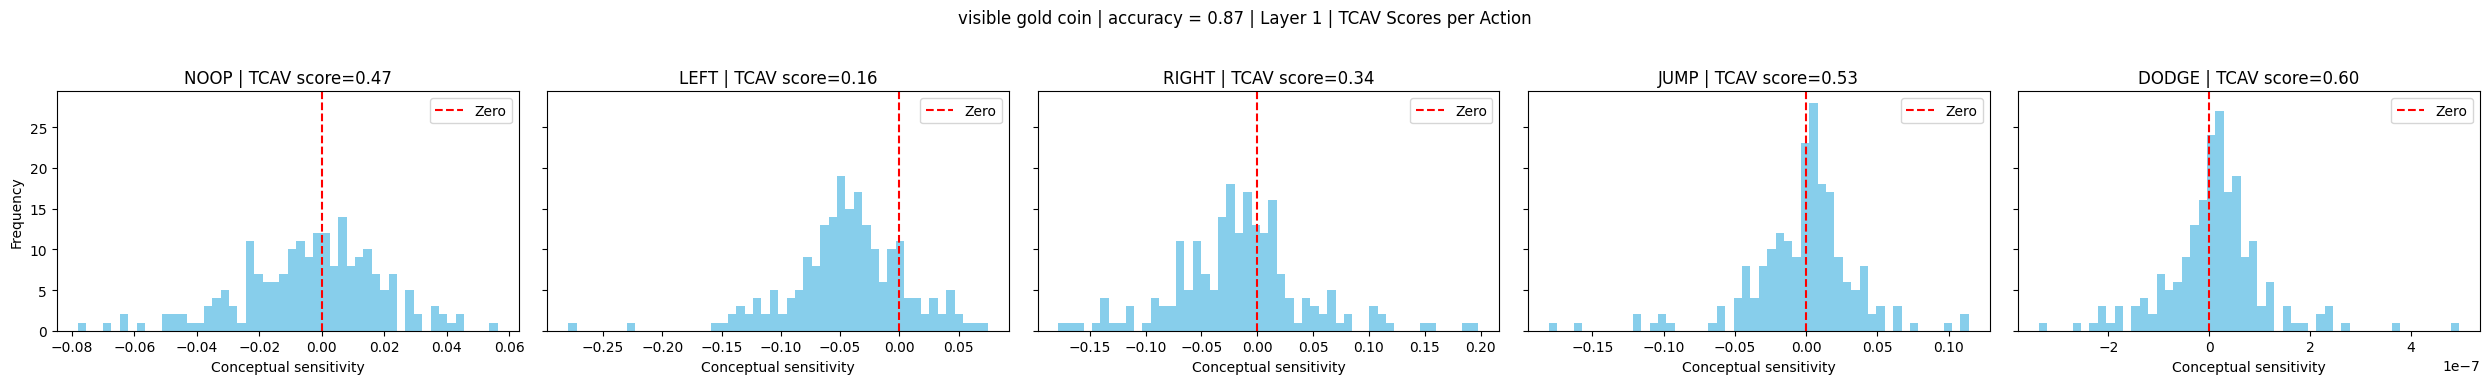

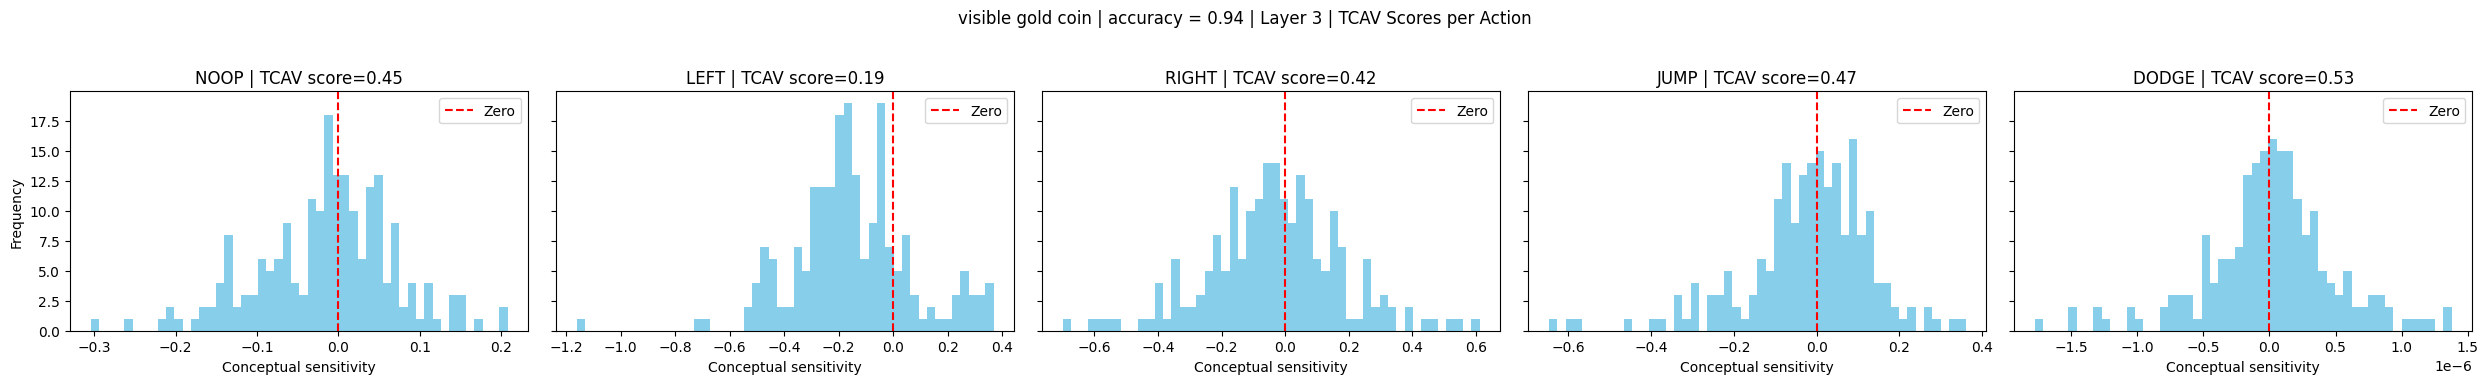

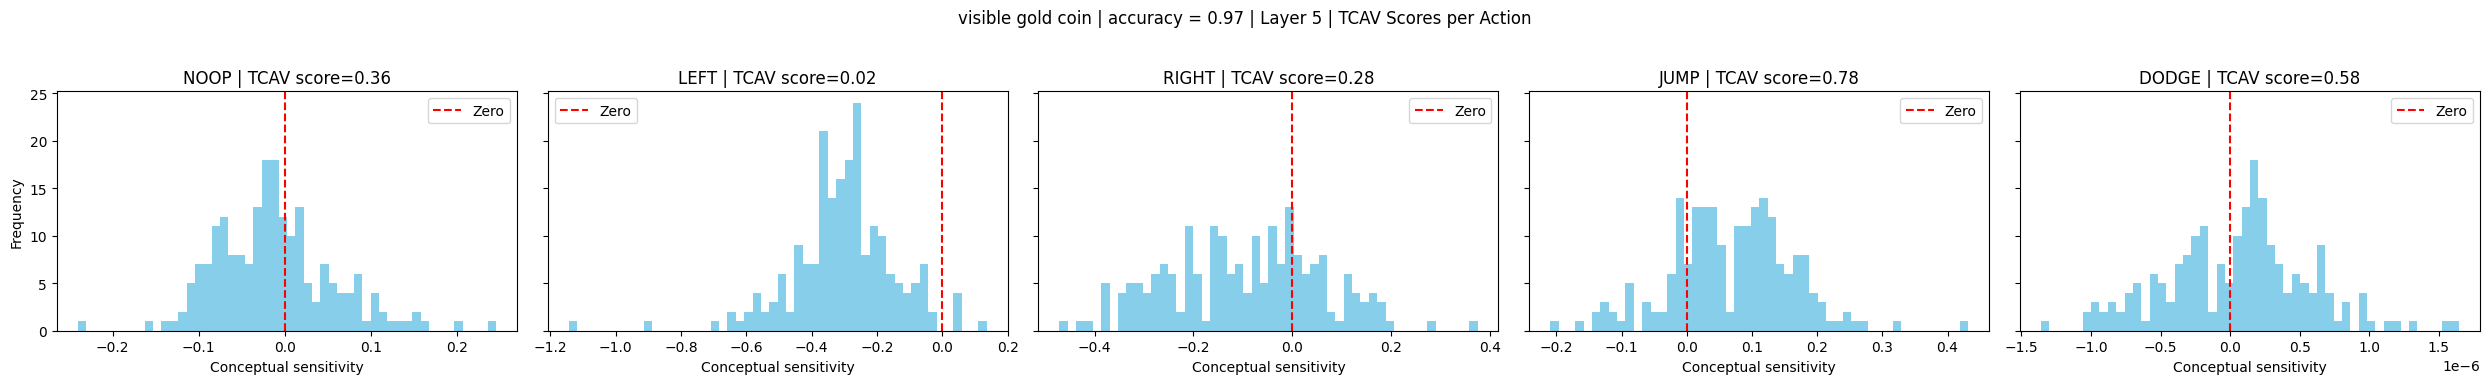

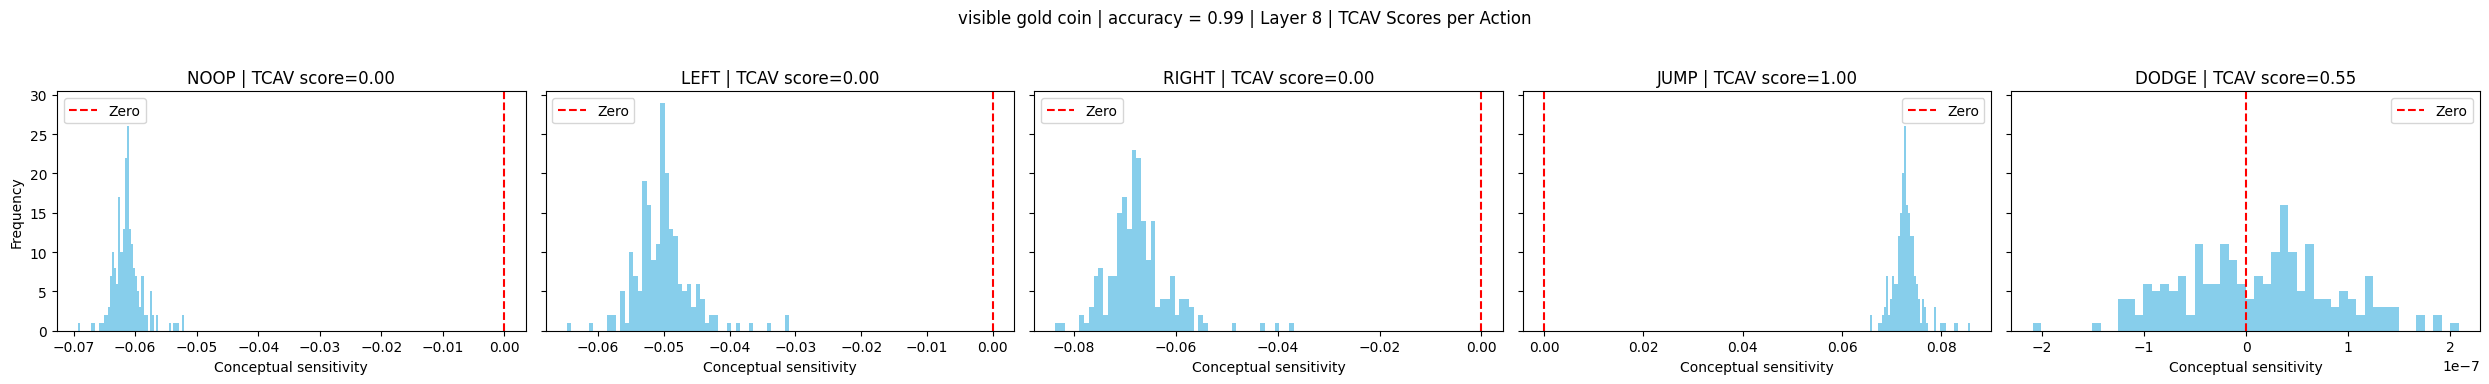

[0.598, 0.529, 0.583, 0.549]


In [23]:
scores = []
for layer in activation_layers:
    scores.append(tcav_softmax(concept_instances['Visible gold coin'], layer))
print(scores)

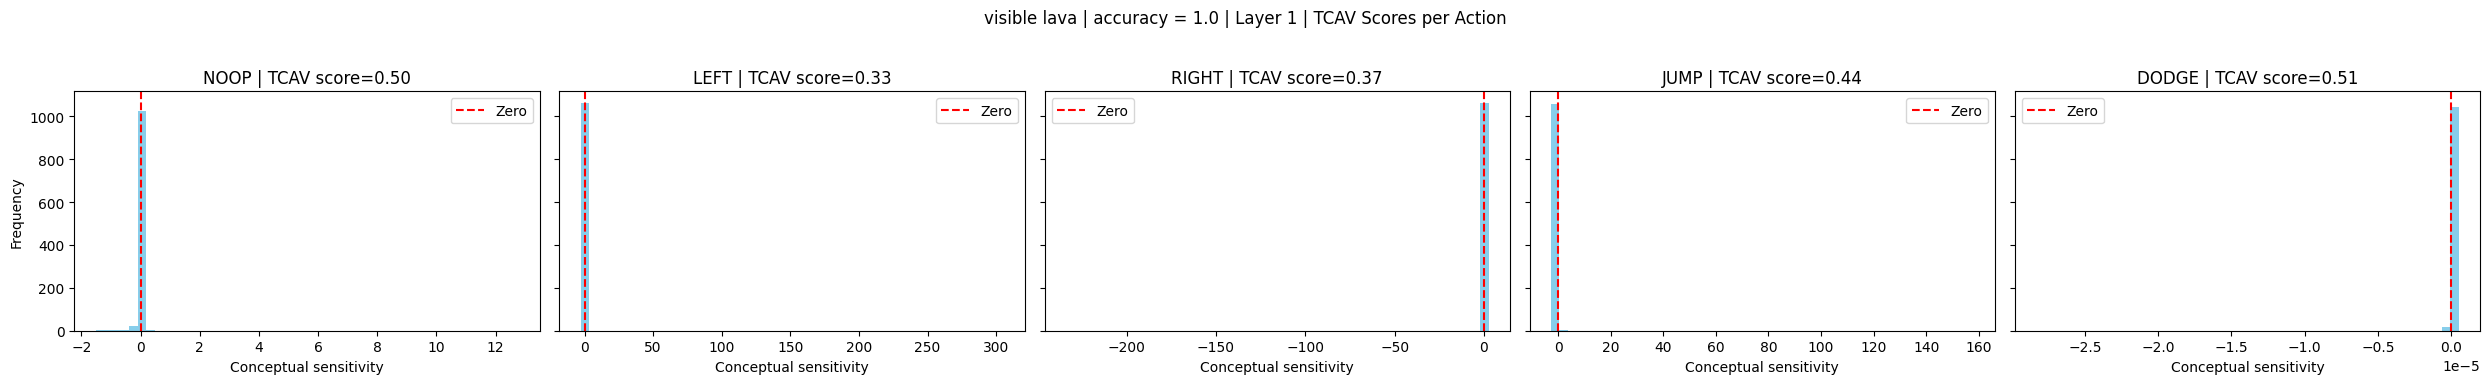

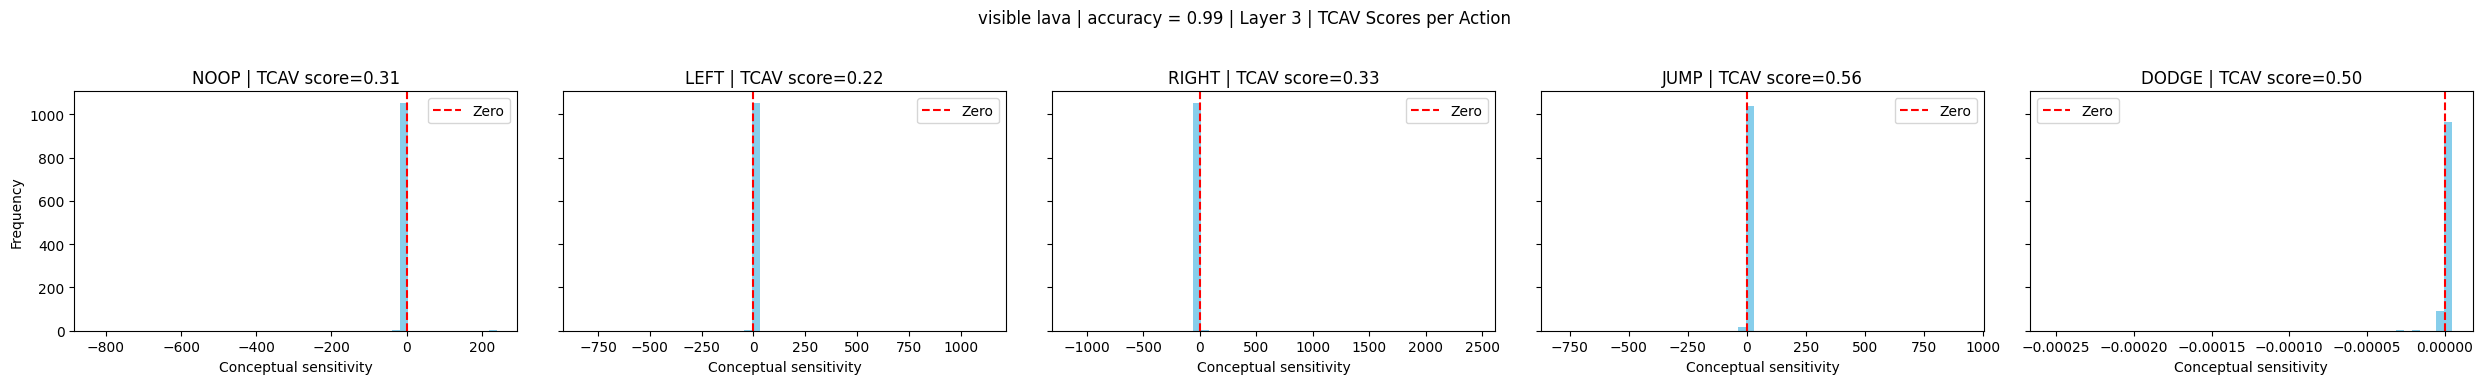

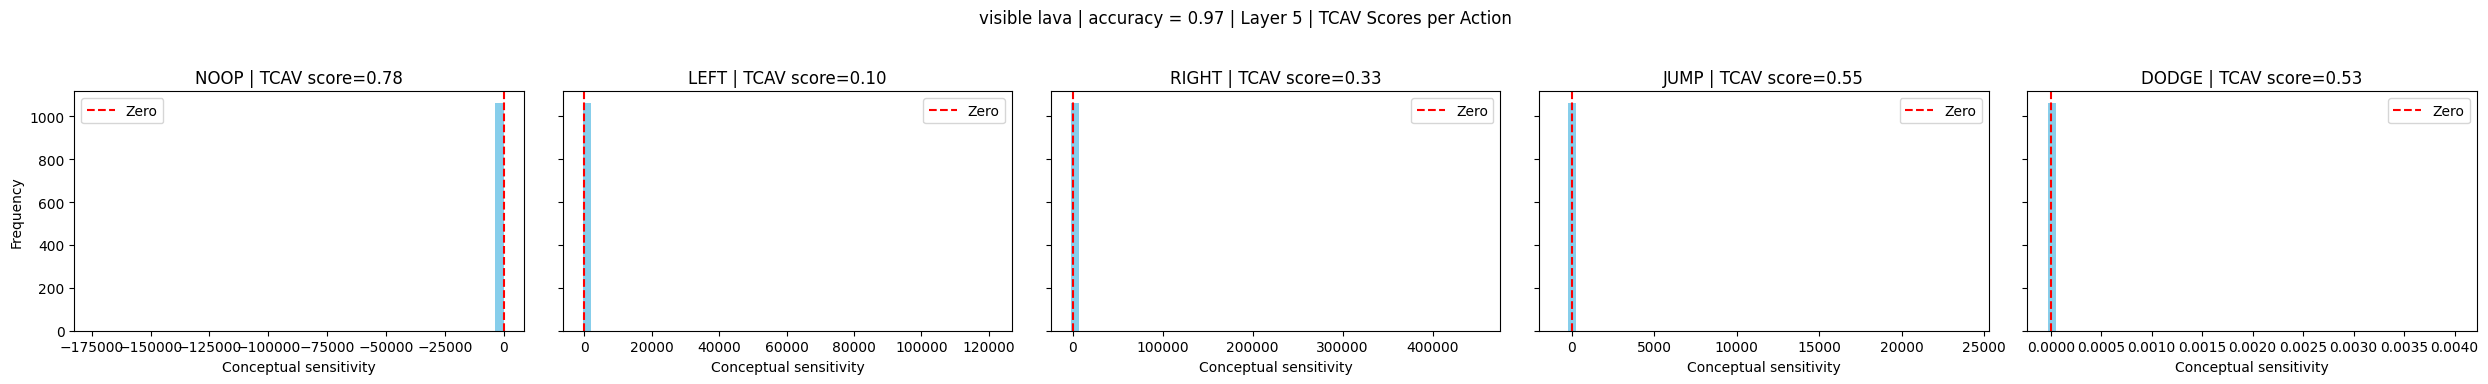

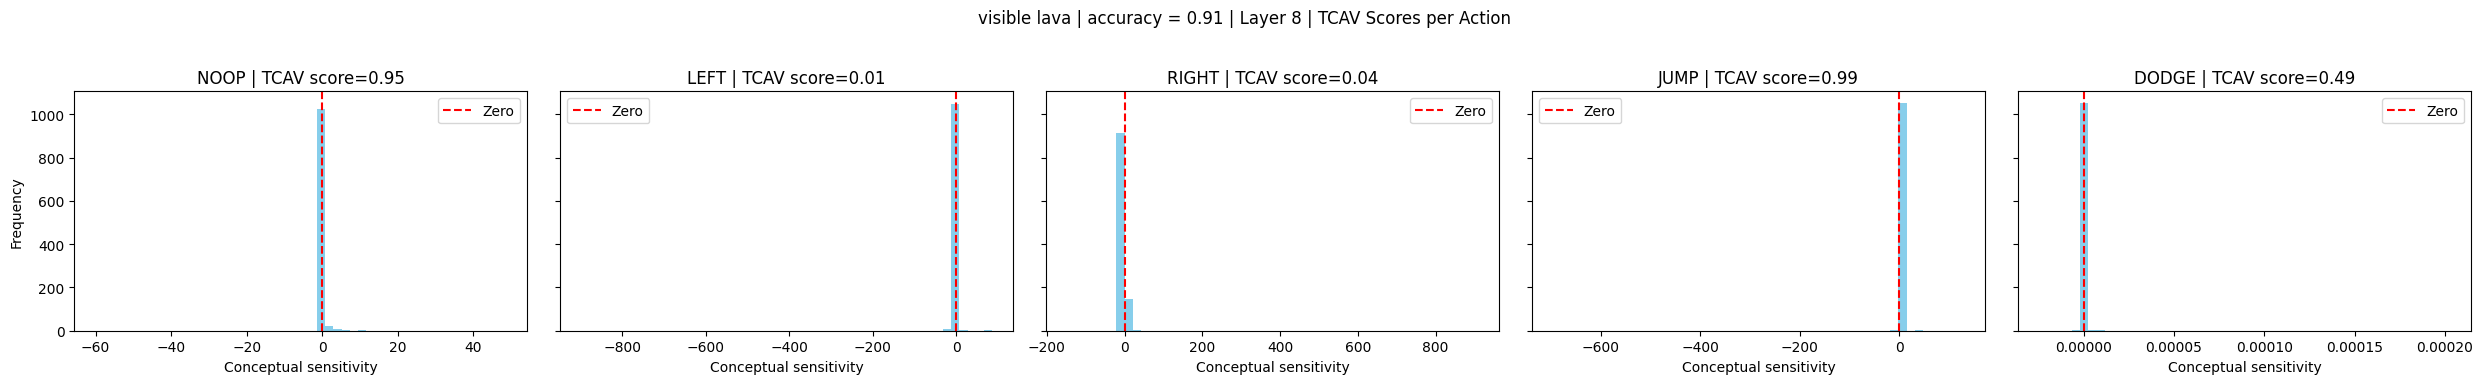

[0.511, 0.495, 0.527, 0.493]


In [46]:
scores = []
for layer in activation_layers:
    scores.append(tcav_linear_softmax(concept_instances['Visible lava'], layer))
print(scores)

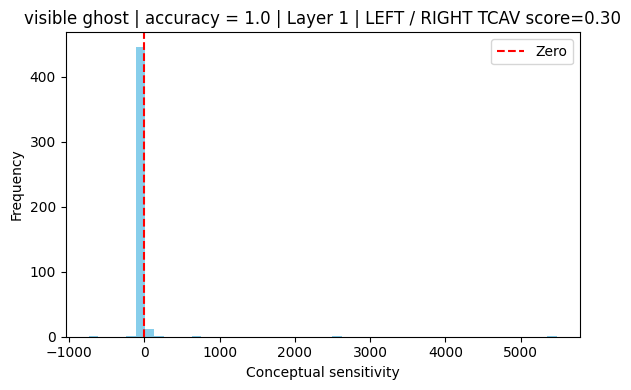

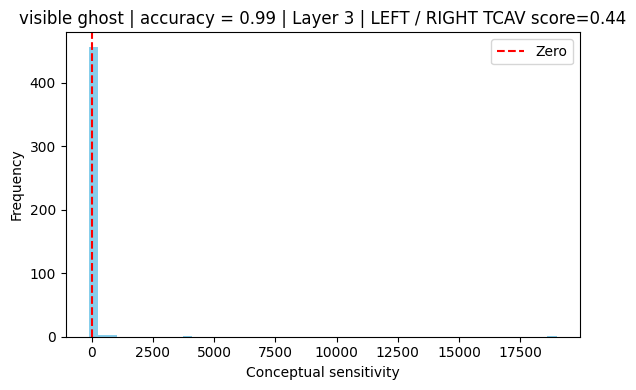

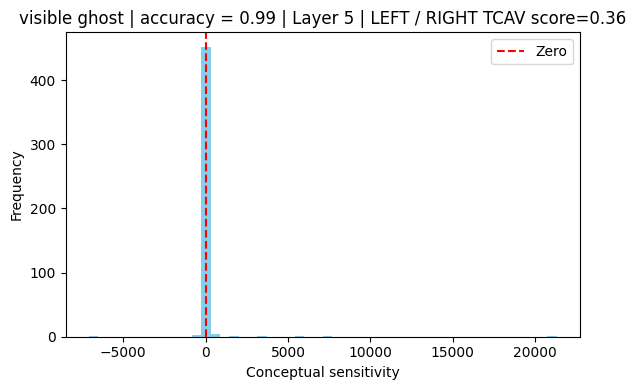

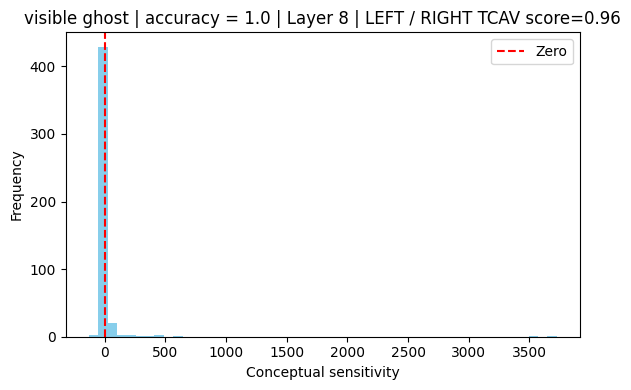

[0.297, 0.438, 0.358, 0.961]


In [58]:
scores = []
for layer in activation_layers:
    scores.append(tcav_action_ratio(concept_instances['Visible ghost'], layer, action_names.index('LEFT'), action_names.index('RIGHT')))
print(scores)